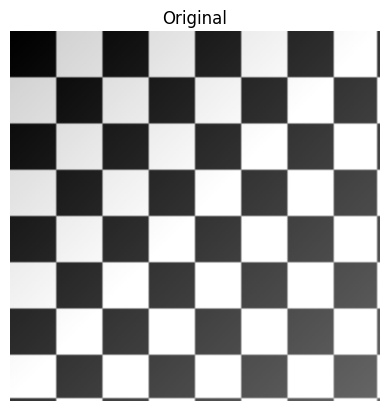

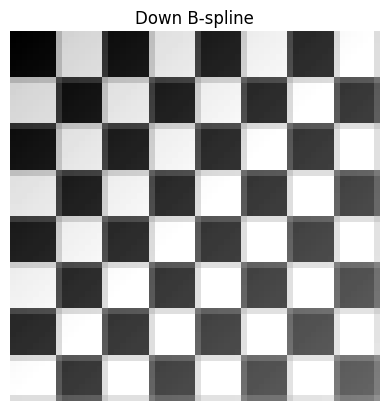

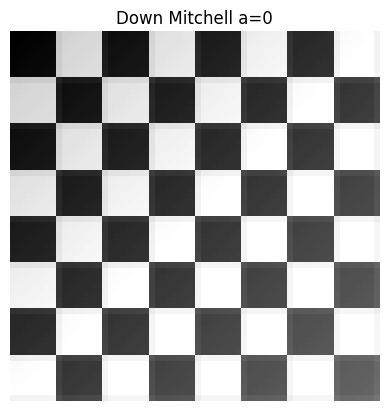

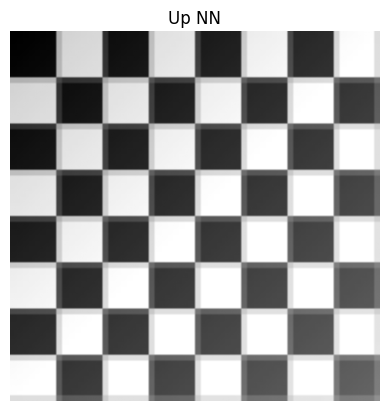

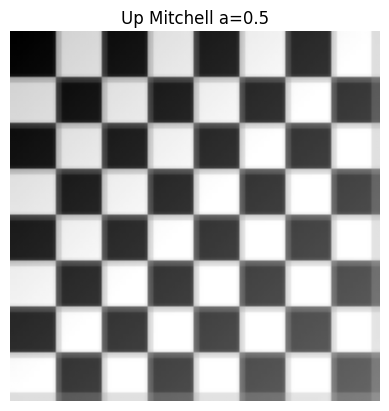

In [1]:
import numpy as np, matplotlib.pyplot as plt

# Kernels
a0_bspline = [1/6, 4/6, 1/6]
a0_mitchell = [0.055, 0.889, 0.055]
a05_mitchell = [0.035, 0.535, 0.535, 0.035]

# Convolution helper
def conv2d(img,k):
    k=np.array(k)/sum(k); p=len(k)//2
    f=lambda v: np.convolve(np.pad(v,(p,p),mode='reflect'),k,'valid')
    if img.ndim==2: return np.apply_along_axis(f,0,np.apply_along_axis(f,1,img))
    return np.stack([conv2d(img[...,c],k) for c in range(img.shape[2])],-1)

# Down/Up

def down2(img,k): return conv2d(img,k)[::2,::2]
def up2_nn(img): return img.repeat(2,0).repeat(2,1)
def up2_mitchell(img): return conv2d(np.kron(img,[[1,0],[0,0]]),a05_mitchell)

# Demo
if __name__=="__main__":
    H=W=128; y,x=np.linspace(0,1,H),np.linspace(0,1,W)
    Y,X=np.meshgrid(y,x,indexing='ij')
    img=((np.floor(X*8)+np.floor(Y*8))%2*0.8+0.2*X+0.2*Y).clip(0,1)

    figs=[("Original",img),
          ("Down B-spline",down2(img,a0_bspline)),
          ("Down Mitchell a=0",down2(img,a0_mitchell)),
          ("Up NN",up2_nn(down2(img,a0_bspline))),
          ("Up Mitchell a=0.5",up2_mitchell(down2(img,a0_bspline)))]

    for t,im in figs:
        plt.figure();plt.imshow(im,cmap='gray');plt.title(t);plt.axis('off')
    plt.show()


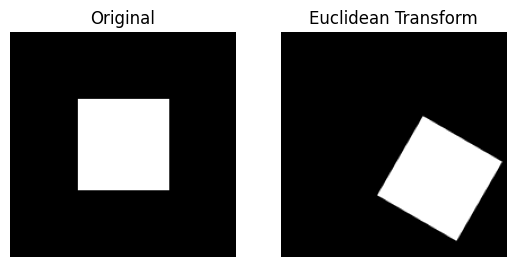

In [7]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Create synthetic test image (white square on black background)
img = np.zeros((200, 200, 3), dtype=np.uint8)
cv2.rectangle(img, (60, 60), (140, 140), (255, 255, 255), -1)

# --- Euclidean transformation parameters ---
theta = np.deg2rad(30)  # rotation angle in radians (30° clockwise)
tx, ty = 40, 30         # translation offsets
cx, cy = 100, 100       # rotation center (image center)

# --- Step 1: Build the homogeneous transformation matrix (Eq. 3.116) ---
R = np.array([
    [np.cos(theta), -np.sin(theta), 0],
    [np.sin(theta),  np.cos(theta), 0],
    [0, 0, 1]
], dtype=np.float32)

T = np.array([
    [1, 0, tx],
    [0, 1, ty],
    [0, 0, 1]
], dtype=np.float32)

# Rotation about point (cx, cy):
# M = Translate_to_origin * Rotation * Translate_back * Translation
Tc = np.array([[1, 0, -cx],
               [0, 1, -cy],
               [0, 0, 1]], dtype=np.float32)

Tc_inv = np.array([[1, 0, cx],
                   [0, 1, cy],
                   [0, 0, 1]], dtype=np.float32)

# Full Euclidean transformation matrix
M_h = T @ (Tc_inv @ (R @ Tc))

# --- Step 2: Warp image using cv2.warpAffine (takes only 2x3) ---
M_affine = M_h[:2, :]  # drop last row
out = cv2.warpAffine(img, M_affine, (img.shape[1], img.shape[0]))

# --- Step 3: Display results ---
plt.subplot(1,2,1)
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.title("Original"); plt.axis("off")

plt.subplot(1,2,2)
plt.imshow(cv2.cvtColor(out, cv2.COLOR_BGR2RGB))
plt.title("Euclidean Transform"); plt.axis("off")
plt.show()


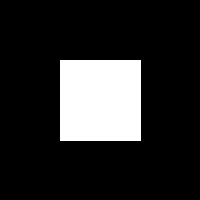

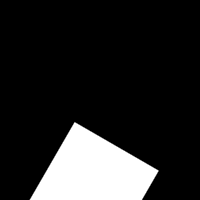

In [5]:
import cv2
import numpy as np
from google.colab.patches import cv2_imshow   # use cv2_imshow instead of cv2.imshow

# Create synthetic image (white square on black background)
img = np.zeros((200, 200, 3), dtype=np.uint8)
cv2.rectangle(img, (60, 60), (140, 140), (255, 255, 255), -1)

# Parameters
k = 1.2           # uniform scaling
angle = 30        # rotation in degrees
tx, ty = 40, 20   # translation

# Convert angle to radians
theta = np.deg2rad(angle)

# Build 2x3 similarity transformation matrix (Eq. 3.119 without bottom row)
M = np.array([
    [k*np.cos(theta), -k*np.sin(theta), k*tx],
    [k*np.sin(theta),  k*np.cos(theta), k*ty]
], dtype=np.float32)

# Apply similarity transform
out = cv2.warpAffine(img, M, (img.shape[1], img.shape[0]))

# Show results in Colab
cv2_imshow(img)
cv2_imshow(out)


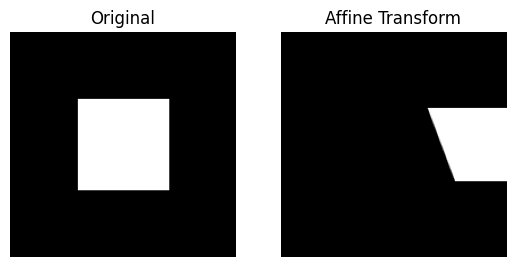

In [6]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Create synthetic test image (white square on black background)
img = np.zeros((200, 200, 3), dtype=np.uint8)
cv2.rectangle(img, (60, 60), (140, 140), (255, 255, 255), -1)

# --- Define an affine transformation matrix (Eq. 3.121, 2x3 part) ---
# Parameters
sx, sy = 1.2, 0.8    # non-uniform scaling
shear = 0.3          # shear along x
tx, ty = 40, 20      # translation

# Build 2x3 affine matrix:
M = np.array([
    [sx, shear, tx],   # a11 a12 a13
    [0,  sy,   ty]     # a21 a22 a23
], dtype=np.float32)

# Apply affine transform
out = cv2.warpAffine(img, M, (img.shape[1], img.shape[0]))

# --- Display with matplotlib (works in Colab) ---
plt.subplot(1,2,1)
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.title("Original"); plt.axis("off")

plt.subplot(1,2,2)
plt.imshow(cv2.cvtColor(out, cv2.COLOR_BGR2RGB))
plt.title("Affine Transform"); plt.axis("off")
plt.show()
